In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')

In [4]:
from AutoValidator import MutliForecaster

## Create Features

In [5]:
# Globals
oneHour = 60
oneDay = 24 * oneHour
oneWeek = oneDay * 7
oneMonth = oneDay * 30

In [6]:
featureNames = []
numSingle = 30

for i in range(1, numSingle):
    featureNames.append(str(i) + '_value')

periods = [5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, oneDay, 2 * oneDay, 5 * oneDay] #, oneWeek, oneMonth]
featureTypes = ['mean', 'stddiv', 'median', 'min', 'max',] #'autocorrelation'

for period in periods:
    for feat in featureTypes:
        featureNames.append(str(period) + '_' + feat)

In [7]:
def create_3d_table(data, featSize, offset, major, minor):
    print(data.shape)
    featureExtractedData = np.zeros((data.shape[1], featSize, data.shape[0] - offset))
    featureExtractedData = featureExtractedData.reshape(featureExtractedData.shape[0] * featureExtractedData.shape[1], featureExtractedData.shape[2])
    
    # Create axis labels
    majorAxis = np.repeat(major, len(minor))
    minorAxis = minor * len(major)

    # create table
    return pd.DataFrame(data=featureExtractedData.T, columns=pd.MultiIndex.from_tuples(zip(majorAxis, minorAxis)))
    

In [8]:
def create_2d_table(data, features, offset):
    print(data.shape)
    
    return pd.DataFrame(data=np.zeros((data.shape[0] - offset, len(features))), columns=features)    

### Add the features

In [9]:
def add_to_predict(df, data, horizon, offset=5 * oneDay):
    for outlook in range(1, horizon + 1):
        for column in df.columns.levels[0]:
            print(column, outlook)
            df[column, 'pred+' + str(outlook)] = data[column].shift(-(outlook - 1))[offset:].values
        
def add_to_predict_2d(df, data, horizon, offset=5 * oneDay):
    for outlook in range(1, horizon + 1):
        print(outlook, end=', ')
        df['pred+' + str(outlook)] = data.shift(-(outlook - 1))[offset:].values

In [10]:
def add_features(df, data, periods, numSingle, offset):
    for column in df.columns.levels[0]:
        print(column)
        for per in periods:
            print(per, end=', ')
            df[column, str(per) + '_mean'] = data[column].rolling(window=per).mean().iloc[offset:].values
            df[column, str(per) + '_stddiv'] = data[column].rolling(window=per).std().iloc[offset:].values
            df[column, str(per) + '_median'] = data[column].rolling(window=per).median().iloc[offset:].values
            df[column, str(per) + '_min'] = data[column].rolling(window=per).min().iloc[offset:].values
            df[column, str(per) + '_max'] = data[column].rolling(window=per).max().iloc[offset:].values
            
        for single in range(1, numSingle):
            print(single)
            df[column, str(single) + '_value'] = data[column].shift(single).iloc[offset:].values
            
def add_features_2d(df, data, periods, numSingle, offset):
    for per in periods:
        print(per, end=', ')
        df[str(per) + '_mean'] = data.rolling(window=per).mean().iloc[offset:].values
        df[str(per) + '_stddiv'] = data.rolling(window=per).std().iloc[offset:].values
        df[str(per) + '_median'] = data.rolling(window=per).median().iloc[offset:].values
        df[str(per) + '_min'] = data.rolling(window=per).min().iloc[offset:].values
        df[str(per) + '_max'] = data.rolling(window=per).max().iloc[offset:].values

    for single in range(1, numSingle):
        print(single, end=', ')
        df[str(single) + '_value'] = data.shift(single).iloc[offset:].values

### Evaluate model

In [11]:
from sklearn.metrics import mean_squared_error

def evaluate_model(data, model, X_test, y_test):
    num_cols = 1 #len(data.columns)

    metrics = {
        'RMSE' : lambda x, y: np.sqrt(mean_squared_error(x, y)),
#         'MASE' : lambda x, y: calculate_MASE(se, x, y)
    }
    num_metrics = len(metrics)

    errors = pd.DataFrame(data=np.zeros(num_metrics), columns=metrics.keys())

    pred = model.predict(X_test)

    for metric_key, metric in metrics.items():
        errors[metric_key] = metric(pred, y_test)

    return errors

In [12]:
def backtest(X: np.ndarray, y :np.ndarray, start: float, num_splits: int):
    """
    Splits a dataset into a train and test set using backtesting with a set size of each test set and a % of data heldout to
    always be in the train set.
    
    data -> A numpy array of pandas dataframe of the data to split
    start -> a value in [0, 1] of the % of data to always be in the train set
    test_step_size -> The size of each test split
    """
    # Need one extra to always have test data
    num_splits += 1
    
    if start < 1:
        start = int(start * len(X))
    splits = np.linspace(start, len(X) - ((len(X) - start) // num_splits), num_splits, dtype=np.int)
    
    train_test_groups = []
    
    for test_start, test_end in zip(splits[:-1], splits[1:]):
        X_train = X.iloc[:test_start]
        X_test  = X.iloc[test_start:test_end]
        y_train = y.iloc[:test_start]
        y_test  = y.iloc[test_start:test_end]
        
        train_test_groups.append([X_train, X_test, y_train, y_test])
        
    return train_test_groups

In [13]:
for i, _ in enumerate(backtest(X, y, 5 * oneDay, 10)):
    print(len(_[0]), len(_[1]), len(_[2]), len(_[3]))

NameError: name 'X' is not defined

In [14]:
import scipy.stats as stats

def compare_hurst(hurst_estimates, results):
    # Linear fit
    %matplotlib notebook
    plt.scatter(hurst_estimates['avg'], results['average'])

    slope, intercept, r_value, p_value, std_err = stats.linregress(hurst_estimates['avg'], results['average'])
    X = np.linspace(0, hurst_estimates['avg'].max() * 1.1, 10)
    plt.xlim([hurst_estimates['avg'].min() * 0.98, hurst_estimates['avg'].max() * 1.02])
    plt.plot(X, intercept + slope * X, c='black', label="y= " + str(round(slope, 2)) + "X + " + str(round(intercept, 2)) + ", R = " + str(round(r_value**2, 2)))
    plt.fill_between(X, intercept + slope * X + std_err, intercept + slope * X - std_err, facecolor='r', alpha=0.5)
    plt.legend()

#  Forecasting

In [15]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor

In [16]:
# Global defines
num_backtest_splits = 10

## 1 minute horizon

In [44]:
horizon = 1
features = featureNames + ['pred+' + str(i) for i in range(1, horizon + 1)]

oneMinModels = []
oneMinResults = pd.DataFrame(np.zeros((len(data.columns), num_backtest_splits)), index=data.columns, columns=['LGBMRegressor_RMSE_' + str(i) for i in range(0, num_backtest_splits)]) # table of [column name] x [repr(model)_RMSE]

In [45]:
for column in data.columns:
    print(column)
    d_table = create_2d_table(data=data[column], features=features, offset=5 * oneDay)
    add_to_predict_2d(df=d_table, data=data[column], offset=5 * oneDay, horizon=horizon)
    add_features_2d(df=d_table, data=data[column], numSingle=numSingle, offset=5 * oneDay, periods=periods)

    # Split into X and y
    to_pred = ['pred+' + str(i) for i in range(1, horizon + 1)]
    XNames = list(set(features) - set(to_pred))
    yNames = to_pred
    X = d_table[XNames]
    y = d_table[yNames]
    
    # Backtest 10 times
    errors = np.zeros(num_backtest_splits)
    for backtest_ind, (X_train, X_test, y_train, y_test) in enumerate(backtest(X, y, oneDay * 5, num_backtest_splits)):
        # Create and train a model
        model = MultiOutputRegressor(LGBMRegressor())
        model.fit(X_train.values, y_train.values[:, :horizon])

        errors[backtest_ind] = evaluate_model(data=data[column], model=model, X_test=X_test, y_test=y_test)['RMSE'][0]

    print()
    print(errors)
    
    oneMinResults.loc[column] = errors
    oneMinModels.append(model)
    
oneMinResults['average'] = oneMinResults.mean(numeric_only=True, axis=1)

window_1_0
(86258,)
1, 5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
[66.84364384 51.7705029  53.75218733 59.43988743 53.45227523 38.52014126
 66.97006189 63.65652358 44.46764829 45.00400865]
window_1_1
(86258,)
1, 5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
[99.2872727  64.43007956 41.08396721 50.04410881 67.74605046 65.61930666
 70.63077949 62.62522566 53.14838013 39.01842829]
window_1_2
(86258,)
1, 5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
[86.44669514 72.1658685  40.68652595 50.60883296 62.60037555 56.93873438
 64.73753583 34.91992006 50.13659876 49.17774242]
window_1_3
(86258,)
1, 5, 10, 20, 30, 40, 5

1, 5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
[98.16805262  8.05929586 18.0825242   6.65034394  5.36485646  2.22158149
 16.8538219   7.43646095  5.75773928  9.66047615]
window_45_7
(86258,)
1, 5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
[13.74058422 44.06648974  8.95527413 12.06651243  7.96171472  7.67473626
  5.4578236   6.08721325 12.58664403 19.80936383]
window_45_8
(86258,)
1, 5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
[22.81372349 22.59323986 14.59282638  6.56651082  6.68325167  5.86645366
 12.32194848  7.28544959 10.73805347  9.74690328]
window_45_9
(86258,)
1, 5, 10, 20, 30, 40, 50, 60, 100, 200, 

In [46]:
oneMinResults.head()

,LGBMRegressor_RMSE_0,LGBMRegressor_RMSE_1,LGBMRegressor_RMSE_2,LGBMRegressor_RMSE_3,LGBMRegressor_RMSE_4,LGBMRegressor_RMSE_5,LGBMRegressor_RMSE_6,LGBMRegressor_RMSE_7,LGBMRegressor_RMSE_8,LGBMRegressor_RMSE_9,average
window_1_0,66.843644,51.770503,53.752187,59.439887,53.452275,38.520141,66.970062,63.656524,44.467648,45.004009,54.387688
window_1_1,99.287273,64.430080,41.083967,50.044109,67.746050,65.619307,70.630779,62.625226,53.148380,39.018428,61.363360
window_1_2,86.446695,72.165868,40.686526,50.608833,62.600376,56.938734,64.737536,34.919920,50.136599,49.177742,56.841883
window_1_3,108.721851,85.195461,94.013822,51.648532,57.522235,48.858497,50.176951,47.904900,60.225497,77.775502,68.204325
window_1_4,109.694507,87.954771,74.913005,83.711026,51.957512,48.149593,44.500598,58.004855,50.804175,64.515476,67.420552


<IPython.core.display.Javascript object>


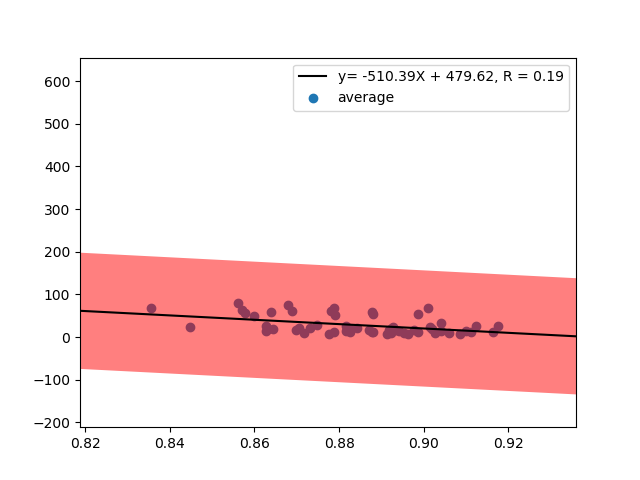

In [62]:
compare_hurst(hurst_estimates, oneMinResults)

In [53]:
oneMinResults.to_csv('results/one_minute_boosted_tree_results.csv')
pickle.dump(oneMinModels, open('results/one_minute_boosted_tree_models', 'wb+'))

## 5 minute horizon

In [17]:
horizon = 5
features = featureNames + ['pred+' + str(i) for i in range(1, horizon + 1)]

fiveMinModels = []
fiveMinResults = pd.DataFrame(np.zeros((len(data.columns), num_backtest_splits)), index=data.columns, columns=['LGBMRegressor_RMSE_' + str(i) for i in range(0, num_backtest_splits)]) # table of [column name] x [repr(model)_RMSE]

In [20]:
for column in data.columns:
    print(column)
    d_table = create_2d_table(data=data[column], features=features, offset=5 * oneDay)
    add_to_predict_2d(df=d_table, data=data[column], offset=5 * oneDay, horizon=horizon)
    add_features_2d(df=d_table, data=data[column], numSingle=numSingle, offset=5 * oneDay, periods=periods)

    # Split into X and y
    to_pred = ['pred+' + str(i) for i in range(1, horizon + 1)]
    XNames = list(set(features) - set(to_pred))
    yNames = to_pred
    X = d_table[XNames]
    y = d_table[yNames]
    
    # Backtest 10 times
    errors = np.zeros(num_backtest_splits)
    for backtest_ind, (X_train, X_test, y_train, y_test) in enumerate(backtest(X, y, oneDay * 5, num_backtest_splits)):
        # Create and train a model
        print(backtest_ind, end=', ')
        model = MultiOutputRegressor(LGBMRegressor())
        model.fit(X_train.values, y_train.values[:, :horizon])

        errors[backtest_ind] = evaluate_model(data=data[column], model=model, X_test=X_test, y_test=y_test)['RMSE'][0]

    print()
    print(errors)
    
    fiveMinResults.loc[column] = errors
    fiveMinModels.append(model)
    
fiveMinResults['average'] = fiveMinResults.mean(numeric_only=True, axis=1)

window_1_0
(86258,)
1, 2, 3, 4, 5, 5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
[187.14846535 151.41729419 153.7135398  177.48221402 150.84456405
 118.96475774 172.79543886 138.05577478 153.03764061 154.45160294]
window_1_1
(86258,)
1, 2, 3, 4, 5, 5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
[231.41564904 141.40989278  91.42817822 133.94341139 223.1981487
 247.07925784 200.16159827 222.36784382 231.81032027 137.01498703]
window_1_2
(86258,)
1, 2, 3, 4, 5, 5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
[279.27673379 253.006

OSError: exception: access violation reading 0x0000000000000278

In [21]:
fiveMinResults.head()

,LGBMRegressor_RMSE_0,LGBMRegressor_RMSE_1,LGBMRegressor_RMSE_2,LGBMRegressor_RMSE_3,LGBMRegressor_RMSE_4,LGBMRegressor_RMSE_5,LGBMRegressor_RMSE_6,LGBMRegressor_RMSE_7,LGBMRegressor_RMSE_8,LGBMRegressor_RMSE_9
window_1_0,187.148465,151.417294,153.713540,177.482214,150.844564,118.964758,172.795439,138.055775,153.037641,154.451603
window_1_1,231.415649,141.409893,91.428178,133.943411,223.198149,247.079258,200.161598,222.367844,231.810320,137.014987
window_1_2,279.276734,253.006527,182.618450,180.252661,207.651118,201.772595,247.386462,119.230014,182.504962,163.934300
window_1_3,319.167303,259.029067,242.191779,192.480054,205.480051,194.626236,206.780322,165.776430,178.397286,248.939917
window_1_4,330.479615,323.618830,267.531365,309.918376,200.005744,167.397144,175.721139,212.966231,204.175891,203.397455


In [ ]:
compare_hurst(hurst_estimates, fiveMinResults)

In [27]:
fiveMinResults.to_csv('results/five_minute_boosted_tree_results.csv')
pickle.dump(fiveMinModels, open('results/five_minute_boosted_tree_models', 'wb+'))

## 60 minute horizon

In [35]:
horizon = 60
features = featureNames + ['pred+' + str(i) for i in range(1, horizon + 1)]

sixtyMinModels = []
sixtyMinResults = pd.DataFrame(np.zeros((len(data.columns), num_backtest_splits)), index=data.columns, columns=['LGBMRegressor_RMSE_' + str(i) for i in range(0, num_backtest_splits)]) # table of [column name] x [repr(model)_RMSE]

In [38]:
from utils.progress import ProgressBar

In [42]:
bar = ProgressBar()
bar.set_length(len(data.columns) * num_backtest_splits)
for column in data.columns:
    d_table = create_2d_table(data=data[column], features=features, offset=5 * oneDay)
    add_to_predict_2d(df=d_table, data=data[column], offset=5 * oneDay, horizon=horizon)
    add_features_2d(df=d_table, data=data[column], numSingle=numSingle, offset=5 * oneDay, periods=periods)

    # Split into X and y
    to_pred = ['pred+' + str(i) for i in range(1, horizon + 1)]
    XNames = list(set(features) - set(to_pred))
    yNames = to_pred
    X = d_table[XNames]
    y = d_table[yNames]
    
    # Backtest 10 times
    errors = np.zeros(num_backtest_splits)
    for backtest_ind, (X_train, X_test, y_train, y_test) in enumerate(backtest(X, y, oneDay * 5, num_backtest_splits)):
        # Create and train a model
#         print(backtest_ind)
        bar.progress()
        model = MultiOutputRegressor(LGBMRegressor())
        model.fit(X_train.values, y_train.values[:, :horizon])

        errors[backtest_ind] = evaluate_model(data=data[column], model=model, X_test=X_test, y_test=y_test)['RMSE'][0]

#     print()
#     print(errors)
    
    sixtyMinResults.loc[column] = errors
    sixtyMinModels.append(model)
    
sixtyMinResults['average'] = sixtyMinResults.mean(numeric_only=True, axis=1)

Progress: [##------------------] 8.7%


KeyboardInterrupt: 

In [ ]:
sixtyMinResults.head()

In [ ]:
compare_hurst(hurst_estimates, sixtyMinResults)

In [53]:
sixtyMinResults.to_csv('results/sixty_minute_boosted_tree_results.csv')
pickle.dump(sixtyMinModels, open('results/sixty_minute_boosted_tree_models', 'wb+'))

window_1_0
(86258,)
1, 5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, (7200, 99) (6532, 1) (6532, 1)


<IPython.core.display.Javascript object>


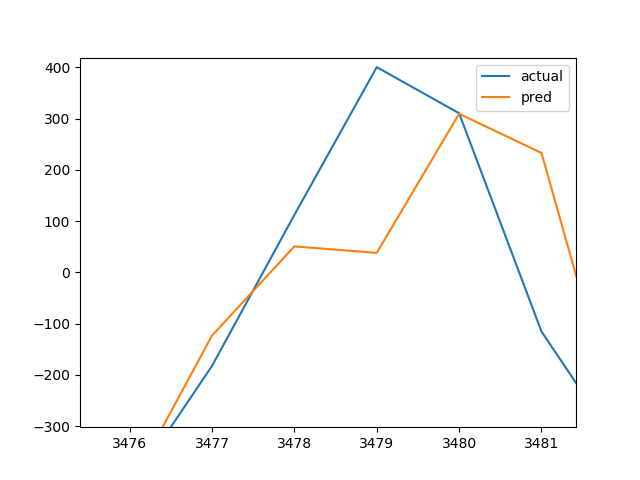

In [49]:
for column in data.columns:
    print(column)
    d_table = create_2d_table(data=data[column], features=features, offset=5 * oneDay)
    add_to_predict_2d(df=d_table, data=data[column], offset=5 * oneDay, horizon=horizon)
    add_features_2d(df=d_table, data=data[column], numSingle=numSingle, offset=5 * oneDay, periods=periods)
    
    # Split into X and y
    to_pred = ['pred+' + str(i) for i in range(1, horizon + 1)]
    XNames = list(set(features) - set(to_pred))
    yNames = to_pred
    X = d_table[XNames]
    y = d_table[yNames]
        
    # Backtest 10 times
    errors = np.zeros(num_backtest_splits)
    for backtest_ind, (X_train, X_test, y_train, y_test) in enumerate(backtest(X, y, oneDay * 5, num_backtest_splits)):
#         print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        # Create and train a model
        model = MultiOutputRegressor(LGBMRegressor())
        model.fit(X_train.values, y_train.values[:, :horizon])
        
#         print(X_train)
        
        print(X_train.shape, y_test.shape, model.predict(X_test).shape)
        %matplotlib notebook
        plt.plot(y_test.values, label='actual')
        plt.plot(model.predict(X_test), label='pred')
        plt.legend()
#         errors[backtest_ind] = evaluate_model(data=data[column], model=model, X_test=X_test, y_test=y_test)['RMSE'][0]
        break
    break

    print()
    print(errors)
    
    oneMinResults.loc[column] = errors
    oneMinModels.append(model)
    
oneMinResults['average'] = oneMinResults.mean(numeric_only=True, axis=1)

In [27]:
columns = ['window_1_0']
t = create_3d_table(data[columns], len(featureNames) + horizon, 5 * oneDay, columns, featureNames + ['pred+' + str(i) for i in range(1, horizon + 1)])

(86304, 1)


In [28]:
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79104 entries, 0 to 79103
Columns: 159 entries, (window_1_0, 1_value) to (window_1_0, pred+60)
dtypes: float64(159)
memory usage: 96.0 MB


In [154]:
add_to_predict(t, data, horizon, 5 * oneDay)
add_features(t, data, periods, numSingle, 5 * oneDay)

window_1_0 1
window_1_0 2
window_1_0 3
window_1_0 4
window_1_0 5
window_1_0 6
window_1_0 7
window_1_0 8
window_1_0 9
window_1_0 10
window_1_0 11
window_1_0 12
window_1_0 13
window_1_0 14
window_1_0 15
window_1_0 16
window_1_0 17
window_1_0 18
window_1_0 19
window_1_0 20
window_1_0 21
window_1_0 22
window_1_0 23
window_1_0 24
window_1_0 25
window_1_0 26
window_1_0 27
window_1_0 28
window_1_0 29
window_1_0 30
window_1_0 31
window_1_0 32
window_1_0 33
window_1_0 34
window_1_0 35
window_1_0 36
window_1_0 37
window_1_0 38
window_1_0 39
window_1_0 40
window_1_0 41
window_1_0 42
window_1_0 43
window_1_0 44
window_1_0 45
window_1_0 46
window_1_0 47
window_1_0 48
window_1_0 49
window_1_0 50
window_1_0 51
window_1_0 52
window_1_0 53
window_1_0 54
window_1_0 55
window_1_0 56
window_1_0 57
window_1_0 58
window_1_0 59
window_1_0 60
window_1_0
5, 10, 20, 30, 40, 50, 60, 100, 200, 350, 500, 1440, 2880, 7200, 1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [155]:
t.info(), pd.isna(t).sum().sum(), t[t == 0].count().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79104 entries, 0 to 79103
Columns: 159 entries, (window_1_0, 1_value) to (window_1_0, pred+60)
dtypes: float64(159)
memory usage: 96.0 MB


(None, 1770, 0)

In [156]:
t.head()

window_1_0                                                                  \
     1_value 2_value 3_value 4_value 5_value 6_value 7_value 8_value 9_value   
0     124.99  125.17  125.35  125.53  125.71  125.90  126.08  126.26  126.44   
1     124.81  124.99  125.17  125.35  125.53  125.71  125.90  126.08  126.26   
2     124.63  124.81  124.99  125.17  125.35  125.53  125.71  125.90  126.08   
3     124.44  124.63  124.81  124.99  125.17  125.35  125.53  125.71  125.90   
4     124.26  124.44  124.63  124.81  124.99  125.17  125.35  125.53  125.71   

             ...                                                            \
  10_value   ...   pred+51 pred+52 pred+53 pred+54 pred+55 pred+56 pred+57   
0   126.62   ...    115.57  115.38  115.20  115.01  114.83  114.64  114.46   
1   126.44   ...    115.38  115.20  115.01  114.83  114.64  114.46  114.27   
2   126.26   ...    115.20  115.01  114.83  114.64  114.46  114.27  114.09   
3   126.08   ...    115.01  114.83  114.64  114.46  114.27  114.09  113.90   
4   125.90   ...    114.83  114.64  114.46  114.27  114.09  113.90  113.72   

                           
  pred+58 pred+59 pred+60  
0  114.27  114.09  113.90  
1  114.09  113.90  113.72  
2  113.90  113.72  113.53  
3  113.72  113.53  113.35  
4  113.53  113.35  113.16  

[5 rows x 159 columns]

In [159]:
t['window_1_0', 'pred+4']

0        124.260
1        124.070
2        123.890
3        123.700
4        123.520
5        123.330
6        123.150
7        122.960
8        122.780
9        122.590
10       122.410
11       122.220
12       122.040
13       121.850
14       121.670
15       121.480
16       121.300
17       121.110
18       120.930
19       120.740
20       120.560
21       120.370
22       120.190
23       120.000
24       119.820
25       119.630
26       119.450
27       119.270
28       119.080
29       118.900
          ...   
79074    -56.265
79075    -56.174
79076    -56.083
79077    -55.992
79078    -55.901
79079    -55.810
79080    -55.719
79081    -55.628
79082    -55.537
79083    -55.446
79084    -55.355
79085    -55.264
79086    -55.173
79087    -55.082
79088    -54.991
79089    -54.900
79090    -54.808
79091    -54.717
79092    -54.626
79093    -54.535
79094    -54.444
79095    -54.353
79096    -54.262
79097    -54.171
79098    -54.089
79099    -54.007
79100    -53.925
79101        N

In [34]:
# Note the std div of a single value is always 0
for column in t.columns:
    if pd.isna(t[column]).sum() > 0:
        print(column, pd.isna(t[column]).sum())

In [160]:
# Train a model on the dataset
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
model = MultiOutputRegressor(LGBMRegressor(), n_jobs=2)

to_pred = ['pred+' + str(i) for i in range(1, horizon + 1)]

# Split into X and y
overallName = t.columns.levels[0][0]
XNames = list(set(t.columns.levels[1]) - set(to_pred))
yNames = to_pred
X = t[pd.MultiIndex.from_tuples(zip(np.repeat(overallName, len(XNames)), XNames))]
y = t[pd.MultiIndex.from_tuples(zip(np.repeat(overallName, len(yNames)), yNames))]

In [161]:
X.shape, y.shape

((79104, 99), (79104, 60))

In [162]:
y.head()

window_1_0                                                                  \
      pred+1  pred+2  pred+3  pred+4  pred+5  pred+6  pred+7  pred+8  pred+9   
0     124.81  124.63  124.44  124.26  124.07  123.89  123.70  123.52  123.33   
1     124.63  124.44  124.26  124.07  123.89  123.70  123.52  123.33  123.15   
2     124.44  124.26  124.07  123.89  123.70  123.52  123.33  123.15  122.96   
3     124.26  124.07  123.89  123.70  123.52  123.33  123.15  122.96  122.78   
4     124.07  123.89  123.70  123.52  123.33  123.15  122.96  122.78  122.59   

            ...                                                            \
  pred+10   ...   pred+51 pred+52 pred+53 pred+54 pred+55 pred+56 pred+57   
0  123.15   ...    115.57  115.38  115.20  115.01  114.83  114.64  114.46   
1  122.96   ...    115.38  115.20  115.01  114.83  114.64  114.46  114.27   
2  122.78   ...    115.20  115.01  114.83  114.64  114.46  114.27  114.09   
3  122.59   ...    115.01  114.83  114.64  114.46  114.27  114.09  113.90   
4  122.41   ...    114.83  114.64  114.46  114.27  114.09  113.90  113.72   

                           
  pred+58 pred+59 pred+60  
0  114.27  114.09  113.90  
1  114.09  113.90  113.72  
2  113.90  113.72  113.53  
3  113.72  113.53  113.35  
4  113.53  113.35  113.16  

[5 rows x 60 columns]

In [163]:
y['window_1_0', 'pred+1'].values

array([124.81 , 124.63 , 124.44 , ..., -54.089, -54.007, -53.925])

In [164]:
y_train['window_1_0'].values.shape

(63283, 60)

In [165]:
m = MultiOutputRegressor(LGBMRegressor())

split = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
m.fit(X_train.values, y_train['window_1_0'].values[:, :horizon])

MultiOutputRegressor(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
           n_jobs=1)

In [177]:
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [178]:
X_test = X_test.iloc[np.arange(0, len(X_test), horizon)]

In [185]:
X_test.index.shape, pred.shape

((264,), (264, 60))

In [190]:
pred = m.predict(X_test)
pred = pred.flatten()

In [191]:
pred.shape

(15840,)

<IPython.core.display.Javascript object>


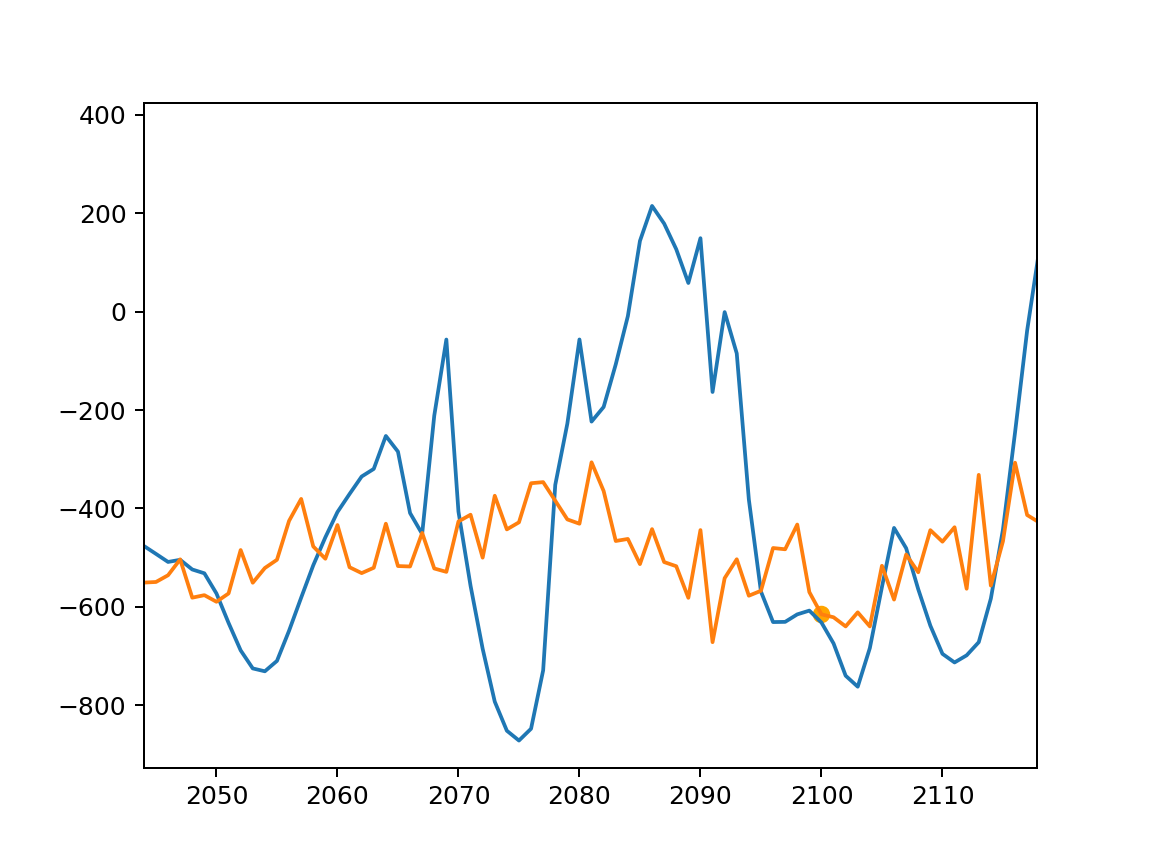

In [192]:
%matplotlib notebook
plt.plot(np.arange(0, len(y_test)), y_test.values[:, 0])
plt.plot(np.arange(0, len(pred)), pred)
plt.scatter(X_test.index - X_test.index[0], pred[X_test.index - X_test.index[0]], c='orange')

In [265]:
pd.isna(data).sum().sum()

0

In [266]:
# Add the values to predict
for outlook in range(1, horizon + 1):
    for column in data.columns:
        print(column, outlook)
        features[column, 'pred+' + str(outlook)] = data[column][5 * oneDay:].values

window_1_0 1
window_1_1 1
window_1_2 1
window_1_3 1
window_1_4 1
window_1_5 1
window_1_6 1
window_1_7 1
window_1_8 1
window_1_9 1
window_1_10 1
window_1_11 1
window_1_12 1
window_1_13 1
window_1_14 1
window_10_0 1
window_10_1 1
window_10_2 1
window_10_3 1
window_10_4 1
window_10_5 1
window_10_6 1
window_10_7 1
window_10_8 1
window_10_9 1
window_10_10 1
window_10_11 1
window_10_12 1
window_10_13 1
window_10_14 1
window_30_0 1
window_30_1 1
window_30_2 1
window_30_3 1
window_30_4 1
window_30_5 1
window_30_6 1
window_30_7 1
window_30_8 1
window_30_9 1
window_30_10 1
window_30_11 1
window_30_12 1
window_30_13 1
window_30_14 1
window_45_0 1
window_45_1 1
window_45_2 1
window_45_3 1
window_45_4 1
window_45_5 1
window_45_6 1
window_45_7 1
window_45_8 1
window_45_9 1
window_45_10 1
window_45_11 1
window_45_12 1
window_45_13 1
window_45_14 1
window_1_0 2
window_1_1 2
window_1_2 2
window_1_3 2
window_1_4 2
window_1_5 2
window_1_6 2
window_1_7 2
window_1_8 2
window_1_9 2
window_1_10 2
window_1_11

window_30_13 11
window_30_14 11
window_45_0 11
window_45_1 11
window_45_2 11
window_45_3 11
window_45_4 11
window_45_5 11
window_45_6 11
window_45_7 11
window_45_8 11
window_45_9 11
window_45_10 11
window_45_11 11
window_45_12 11
window_45_13 11
window_45_14 11
window_1_0 12
window_1_1 12
window_1_2 12
window_1_3 12
window_1_4 12
window_1_5 12
window_1_6 12
window_1_7 12
window_1_8 12
window_1_9 12
window_1_10 12
window_1_11 12
window_1_12 12
window_1_13 12
window_1_14 12
window_10_0 12
window_10_1 12
window_10_2 12
window_10_3 12
window_10_4 12
window_10_5 12
window_10_6 12
window_10_7 12
window_10_8 12
window_10_9 12
window_10_10 12
window_10_11 12
window_10_12 12
window_10_13 12
window_10_14 12
window_30_0 12
window_30_1 12
window_30_2 12
window_30_3 12
window_30_4 12
window_30_5 12
window_30_6 12
window_30_7 12
window_30_8 12
window_30_9 12
window_30_10 12
window_30_11 12
window_30_12 12
window_30_13 12
window_30_14 12
window_45_0 12
window_45_1 12
window_45_2 12
window_45_3 12
win

window_45_11 21
window_45_12 21
window_45_13 21
window_45_14 21
window_1_0 22
window_1_1 22
window_1_2 22
window_1_3 22
window_1_4 22
window_1_5 22
window_1_6 22
window_1_7 22
window_1_8 22
window_1_9 22
window_1_10 22
window_1_11 22
window_1_12 22
window_1_13 22
window_1_14 22
window_10_0 22
window_10_1 22
window_10_2 22
window_10_3 22
window_10_4 22
window_10_5 22
window_10_6 22
window_10_7 22
window_10_8 22
window_10_9 22
window_10_10 22
window_10_11 22
window_10_12 22
window_10_13 22
window_10_14 22
window_30_0 22
window_30_1 22
window_30_2 22
window_30_3 22
window_30_4 22
window_30_5 22
window_30_6 22
window_30_7 22
window_30_8 22
window_30_9 22
window_30_10 22
window_30_11 22
window_30_12 22
window_30_13 22
window_30_14 22
window_45_0 22
window_45_1 22
window_45_2 22
window_45_3 22
window_45_4 22
window_45_5 22
window_45_6 22
window_45_7 22
window_45_8 22
window_45_9 22
window_45_10 22
window_45_11 22
window_45_12 22
window_45_13 22
window_45_14 22
window_1_0 23
window_1_1 23
win

window_10_5 32
window_10_6 32
window_10_7 32
window_10_8 32
window_10_9 32
window_10_10 32
window_10_11 32
window_10_12 32
window_10_13 32
window_10_14 32
window_30_0 32
window_30_1 32
window_30_2 32
window_30_3 32
window_30_4 32
window_30_5 32
window_30_6 32
window_30_7 32
window_30_8 32
window_30_9 32
window_30_10 32
window_30_11 32
window_30_12 32
window_30_13 32
window_30_14 32
window_45_0 32
window_45_1 32
window_45_2 32
window_45_3 32
window_45_4 32
window_45_5 32
window_45_6 32
window_45_7 32
window_45_8 32
window_45_9 32
window_45_10 32
window_45_11 32
window_45_12 32
window_45_13 32
window_45_14 32
window_1_0 33
window_1_1 33
window_1_2 33
window_1_3 33
window_1_4 33
window_1_5 33
window_1_6 33
window_1_7 33
window_1_8 33
window_1_9 33
window_1_10 33
window_1_11 33
window_1_12 33
window_1_13 33
window_1_14 33
window_10_0 33
window_10_1 33
window_10_2 33
window_10_3 33
window_10_4 33
window_10_5 33
window_10_6 33
window_10_7 33
window_10_8 33
window_10_9 33
window_10_10 33
wind

window_10_3 42
window_10_4 42
window_10_5 42
window_10_6 42
window_10_7 42
window_10_8 42
window_10_9 42
window_10_10 42
window_10_11 42
window_10_12 42
window_10_13 42
window_10_14 42
window_30_0 42
window_30_1 42
window_30_2 42
window_30_3 42
window_30_4 42
window_30_5 42
window_30_6 42
window_30_7 42
window_30_8 42
window_30_9 42
window_30_10 42
window_30_11 42
window_30_12 42
window_30_13 42
window_30_14 42
window_45_0 42
window_45_1 42
window_45_2 42
window_45_3 42
window_45_4 42
window_45_5 42
window_45_6 42
window_45_7 42
window_45_8 42
window_45_9 42
window_45_10 42
window_45_11 42
window_45_12 42
window_45_13 42
window_45_14 42
window_1_0 43
window_1_1 43
window_1_2 43
window_1_3 43
window_1_4 43
window_1_5 43
window_1_6 43
window_1_7 43
window_1_8 43
window_1_9 43
window_1_10 43
window_1_11 43
window_1_12 43
window_1_13 43
window_1_14 43
window_10_0 43
window_10_1 43
window_10_2 43
window_10_3 43
window_10_4 43
window_10_5 43
window_10_6 43
window_10_7 43
window_10_8 43
windo

window_30_11 51
window_30_12 51
window_30_13 51
window_30_14 51
window_45_0 51
window_45_1 51
window_45_2 51
window_45_3 51
window_45_4 51
window_45_5 51
window_45_6 51
window_45_7 51
window_45_8 51
window_45_9 51
window_45_10 51
window_45_11 51
window_45_12 51
window_45_13 51
window_45_14 51
window_1_0 52
window_1_1 52
window_1_2 52
window_1_3 52
window_1_4 52
window_1_5 52
window_1_6 52
window_1_7 52
window_1_8 52
window_1_9 52
window_1_10 52
window_1_11 52
window_1_12 52
window_1_13 52
window_1_14 52
window_10_0 52
window_10_1 52
window_10_2 52
window_10_3 52
window_10_4 52
window_10_5 52
window_10_6 52
window_10_7 52
window_10_8 52
window_10_9 52
window_10_10 52
window_10_11 52
window_10_12 52
window_10_13 52
window_10_14 52
window_30_0 52
window_30_1 52
window_30_2 52
window_30_3 52
window_30_4 52
window_30_5 52
window_30_6 52
window_30_7 52
window_30_8 52
window_30_9 52
window_30_10 52
window_30_11 52
window_30_12 52
window_30_13 52
window_30_14 52
window_45_0 52
window_45_1 52
w

In [267]:
data['window_1_0'][5 * oneDay:].shape, features.shape

((79104,), (79104, 9840))

In [268]:
pd.isna(features['window_1_0', 'pred+1']).sum()

0

In [269]:
# Add the moving average
['mean', 'stddiv', 'median', 'min', 'max',]
for column in data.columns:
    print(column)
    for per in periods:
        print(per, end=', ')
        features[column, str(per) + '_mean'] = data[column].rolling(window=per).mean().iloc[oneDay:]
        features[column, str(per) + 'stddiv'] = data[column].rolling(window=per).std().iloc[oneDay:]
        features[column, str(per) + '_median'] = data[column].rolling(window=per).median().iloc[oneDay:]
        features[column, str(per) + '_min'] = data[column].rolling(window=per).min().iloc[oneDay:]
        features[column, str(per) + '_max'] = data[column].rolling(window=per).max().iloc[oneDay:]

1
5
10
20
30
40
50
60
100
200
350
500
1440
2880
7200
1
5
10
20
30
40
50
60
100
200
350
500
1440
2880
7200
1
5
10
20
30
40
50
60
100
200
350
500
1440
2880
7200
1
5
10
20
30
40
50
60
100
200
350
500
1440
2880
7200
1
5
10
20
30
40
50
60
100
200
350
500
1440
2880
7200
1
5
10
20
30
40
50
60
100
200
350
500
1440
2880
7200
1
5
10
20
30
40
50
60
100
200


MemoryError: 

In [280]:
features.shape

(79104, 9940)

In [277]:
features.to_hdf('data/tree_feats.h5', 'test')

ValueError: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 192 from PyObject

In [ ]:
!pip updates numpy

In [258]:
offset = 5 * oneDay
featureExtractedData = np.zeros((data.shape[1], len(featureNames) + horizon, data.shape[0] - offset))

In [260]:
featureExtractedData = featureExtractedData.reshape(featureExtractedData.shape[0] * featureExtractedData.shape[1], featureExtractedData.shape[2])

In [261]:
major, minor = data.columns, featureNames + ['pred+' + str(i) for i in range(1, horizon + 1)]
majorAxis = np.repeat(major, len(minor))
minorAxis = minor * len(major)

In [262]:
featureExtractedData.shape, len(list(zip(majorAxis, minorAxis)))

((9840, 79104), 9840)

In [263]:
features = pd.DataFrame(data=featureExtractedData.T, columns=pd.MultiIndex.from_tuples(zip(majorAxis, minorAxis)))

In [264]:
features.head()

window_1_0                                                                  \
     value_1 value_2 value_3 value_4 value_5 value_6 value_7 value_8 value_9   
0        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

             ...   window_45_14                                          \
  value_10   ...        pred+51 pred+52 pred+53 pred+54 pred+55 pred+56   
0      0.0   ...            0.0     0.0     0.0     0.0     0.0     0.0   
1      0.0   ...            0.0     0.0     0.0     0.0     0.0     0.0   
2      0.0   ...            0.0     0.0     0.0     0.0     0.0     0.0   
3      0.0   ...            0.0     0.0     0.0     0.0     0.0     0.0   
4      0.0   ...            0.0     0.0     0.0     0.0     0.0     0.0   

                                   
  pred+57 pred+58 pred+59 pred+60  
0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0  
4     0.0     0.0     0.0     0.0  

[5 rows x 9840 columns]

In [14]:
offset = oneMonth
featureExtractedData = np.empty((data.shape[0], data.shape[1] + horizon, data.shape[0]))

for i ,point in enumerate(data.values[offset:]):
    if i % 5000 == 0:
        print(str(i // 5000), '/', len(data.values) // 5000)

    # The labels are the next n values
    try:
        featureExtractedData[]
#         labelsData.append(np.array(data.values[offset + i + 1: offset + i + horizon + 1].reshape(1, horizon)[0]))
    except:
        break
        
    # Generate the features
    values = np.zeros(len(featureNames))

    
    values[:numSingle] = data.values[offset + i - 1 - numSingle : offset + i - 1 ].reshape(numSingle)
#     for j in range(0, numSingle):
#         values[j] = data.values[offset + i - 1 - j]
    

    for j, period in enumerate(periods):
        periodData = data.values[offset + i - period: offset + i]
        values[numSingle - 1 + j * len(featureTypes) + 0] = np.mean(periodData)
        values[numSingle - 1 + j * len(featureTypes) + 1] = np.std(periodData)
        values[numSingle - 1 + j * len(featureTypes) + 2] = np.median(periodData)
        values[numSingle - 1 + j * len(featureTypes) + 3] = np.min(periodData)
        values[numSingle - 1 + j * len(featureTypes) + 4] = np.max(periodData)
        
    featureExtractedData.append(values)

# Convert to numpy arrays
# featureExtractedData = np.array(featureExtractedData)
# labels = np.array(labelsData)


0.0 / 86.304


In [14]:
# Convert to numpy arrays
featureExtractedData = np.array(featureExtractedData)
labels = np.array(labelsData)

In [47]:
print(len(featureExtractedData), len(labels))

6795 6795


In [48]:
features = pd.DataFrame(featureExtractedData, columns = featureNames)

In [49]:
labels = pd.DataFrame(labels, columns = [str(i) for i in range(1, 6)])

In [50]:
labels.head()

,1,2,3,4,5
0,120.20,120.26,120.32,120.38,120.44
1,120.26,120.32,120.38,120.44,120.50
2,120.32,120.38,120.44,120.50,120.56
3,120.38,120.44,120.50,120.56,120.62
4,120.44,120.50,120.56,120.62,120.68


In [51]:
features.head()

,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,...,2880_mean,2880_stddiv,2880_median,2880_min,2880_max,7200_mean,7200_stddiv,7200_median,7200_min,7200_max
0,119.56,119.58,119.60,119.61,119.63,119.65,119.67,119.68,119.70,119.72,...,5.291448,417.465994,182.50,-1473.1,918.23,0.202500,450.183352,191.205,-1473.1,918.23
1,119.58,119.60,119.61,119.63,119.65,119.67,119.68,119.70,119.72,119.73,...,5.220921,417.429426,182.48,-1473.1,918.23,0.187237,450.177423,191.200,-1473.1,918.23
2,119.60,119.61,119.63,119.65,119.67,119.68,119.70,119.72,119.73,119.75,...,5.150577,417.392973,182.46,-1473.1,918.23,0.171967,450.171486,191.170,-1473.1,918.23
3,119.61,119.63,119.65,119.67,119.68,119.70,119.72,119.73,119.75,119.77,...,5.080421,417.356637,182.44,-1473.1,918.23,0.156687,450.165543,191.105,-1473.1,918.23
4,119.63,119.65,119.67,119.68,119.70,119.72,119.73,119.75,119.77,119.79,...,5.010448,417.320416,182.42,-1473.1,918.23,0.141400,450.159593,191.040,-1473.1,918.23


In [52]:
print("Shape of features: ", features.shape, " shape of labels: ", labels.shape)

Shape of features:  (6795, 104)  shape of labels:  (6795, 5)


In [53]:
# Save the data
import pickle

pickle.dump(features, open('treeFeats_10-10-18', 'wb'))
pickle.dump(labels, open('treeLabels_10-10-18', 'wb'))

## Load data

In [9]:
import pickle
features = pickle.load(open('treeFeats_27-9-18', 'rb'))
labels   = pickle.load(open('treeLabels_27-9-18', 'rb'))

### Backtesting
Back testing is a test / training split method for time series data.<br>
Backtesting is like k-fold cross validation and produces n sets of data to test and train on.

In [22]:
from sklearn.model_selection import TimeSeriesSplit

ts = TimeSeriesSplit(max_train_size=None, n_splits=10)

X_trainData = []
for train_index, test_index in ts.split(data):
    X_trainData.append((data.values[train_index], data.values[test_index]))
    #X_train, X_test = data.values[train_index], data.values[test_index]
    #y_train, y_test = data.values[train_index], data.values[test_index]

In [23]:
print(len(X_trainData), len(X_test))

NameError: name 'X_test' is not defined

In [21]:
print(X_train[:10])

[[39.066]
 [38.992]
 [38.919]
 [38.845]
 [38.772]
 [38.698]
 [38.624]
 [38.551]
 [38.477]
 [38.403]]


In [17]:
print(X_test[:10])

[[257.55]
 [258.11]
 [256.42]
 [254.58]
 [250.57]
 [246.48]
 [243.09]
 [231.66]
 [220.88]
 [202.38]]


### My backtesting implementation

In [24]:
labels = data[2000:]

In [153]:
# Split the data
X_train, X_test = features.loc[:int(len(features) * 0.8)], features.loc[int(len(features) * 0.8):]
Y_train, Y_test = labels[:int(len(features) * 0.8)], labels[int(len(features) * 0.8):]

X_train = X_train[:-1]


In [154]:
def split(data, splits = 10, offset = 0, ratio = 0.2):
    result = []
    
    for i in range(0, splits):
        start = int( offset + (i / splits) * (len(data) - offset)   )
        end   = int( offset + ((i + 1) / splits) * (len(data) - offset) )
        print(start, end)
        
        tempData = data[0: end]
        train, test = tempData[0: int(0.8 * len(tempData))], tempData[int(0.8 * len(tempData)):] 
        
        result.append((train, test))
        
    return result

In [155]:
splits = 5

trainingSets = split(features.values, 20, 4000)

4000 4139
4139 4279
4279 4419
4419 4559
4559 4698
4698 4838
4838 4978
4978 5118
5118 5257
5257 5397
5397 5537
5537 5677
5677 5816
5816 5956
5956 6096
6096 6236
6236 6375
6375 6515
6515 6655
6655 6795


In [57]:
print(len(trainingSets[0][0]))

3311


This is not valid as the previous value is a feature

## Tree based model

In [62]:
from xgboost import XGBRegressor

In [131]:
xgb_reg = XGBRegressor(n_estimators=3000, learning_rate=0.1, colsample_bytree=0.3)

In [132]:
xgb_reg.fit(X_train, Y_train)

ValueError: DataFrame for label cannot have multiple columns

In [174]:
Y_pred = xgb_reg.predict(X_test)

[<matplotlib.lines.Line2D at 0x1d3802b0>]

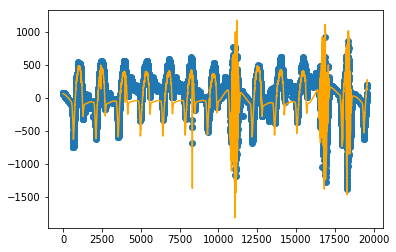

In [175]:
plt.scatter(np.linspace(0, len(Y_pred), len(Y_pred)), Y_pred)
plt.plot(np.linspace(0, len(Y_pred), len(Y_pred)), Y_test, c = 'orange')

In [119]:
Y_test.head()

,39.14
80400,63.360
80401,63.258
80402,63.156
80403,63.054
80404,62.952


In [122]:
Y_pred

array([ 73.50389,  71.50631,  71.50631, ..., 280.80487, 271.1822 ,
       269.55948], dtype=float32)

In [124]:
from sklearn.metrics import mean_squared_error

In [176]:
mean_squared_error(Y_pred, Y_test)


33239.506999045756

In [ ]:
import shap

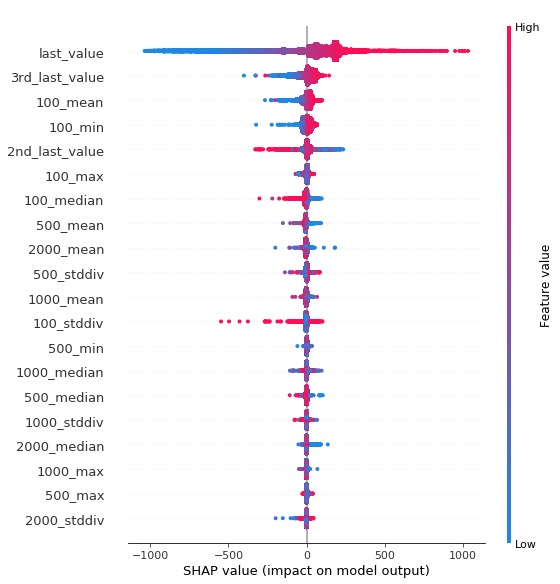

In [127]:
shap_values = shap.TreeExplainer(xgb_reg).shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=20)

### Fixing feature creation

A previous error is that the features are being created from the real data and not the predicted values. This is fixed below:

In [58]:
dataIncludingPredictions = data.values.copy()

In [ ]:
offset = len(dataIncludingPredictions)

predictions = []

for i in range(0, 60):
    values = np.zeros(len(featureNames))

    if i % 1 == 0:
        print(str(i / 1000), '/', len(dataIncludingPredictions) / 1000)
    
    values[0]   = dataIncludingPredictions[offset + i - 1]
    values[1]   = dataIncludingPredictions[offset + i - 2]
    values[2]   = dataIncludingPredictions[offset + i - 3]
    

    for j, period in enumerate(periods):
        periodData = dataIncludingPredictions[offset + i - period: offset + i]
        values[3 + j * len(featureTypes) + 0] = np.mean(periodData)
        values[3 + j * len(featureTypes) + 1] = np.std(periodData)
        values[3 + j * len(featureTypes) + 2] = np.median(periodData)
        values[3 + j * len(featureTypes) + 3] = np.min(periodData)
        values[3 + j * len(featureTypes) + 4] = np.max(periodData)
        
#     print("V", len(values), np.array([values]).shape)
    predictionFeatures = pd.DataFrame(np.array([values]), columns = featureNames)
#     print(predictionFeatures)

    # Make a prediction
    pred = xgb_reg.predict(predictionFeatures)
    predictions.append(pred)
    
    # TODO: OPTIMISE THIS
    dataIncludingPredictions = np.append(dataIncludingPredictions, pred)
    print(len(dataIncludingPredictions))


0.0 / 102.0
102001
0.001 / 102.001
102002
0.002 / 102.002
102003
0.003 / 102.003
102004
0.004 / 102.004
102005
0.005 / 102.005
102006
0.006 / 102.006
102007
0.007 / 102.007
102008
0.008 / 102.008
102009


In [178]:
Y_pred = np.array(predictions)

Text(0,0.5,'Output power')

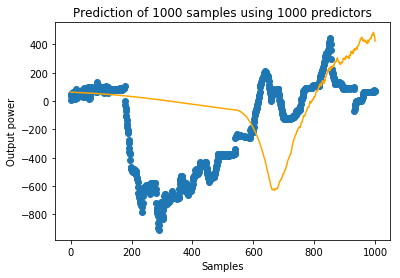

In [179]:
plt.scatter(np.linspace(0, len(Y_pred), len(Y_pred)), Y_pred)
plt.plot(np.linspace(0, len(Y_pred), len(Y_pred)), Y_test[:1000], c = 'orange')
plt.title('Prediction of 1000 samples using 1000 predictors')
plt.xlabel('Samples')
plt.ylabel('Output power')

In [166]:
print(len(Y_pred))

1000


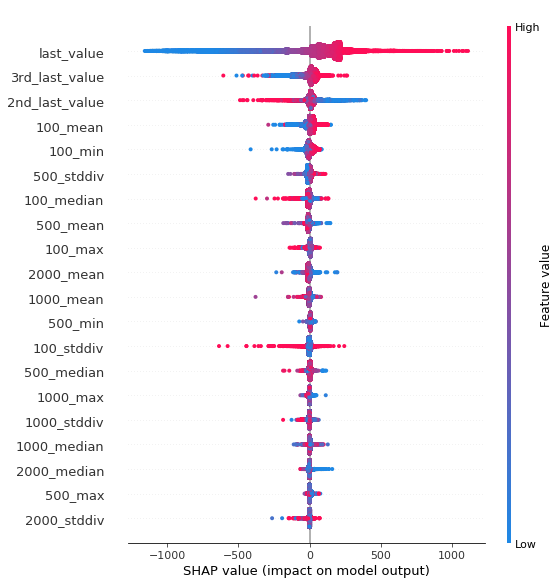

In [180]:
shap_values = shap.TreeExplainer(xgb_reg).shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=20)

### Thoughts on this approach

1. Requires more validation <br>
2. Not very accurate over 100 - 200 samples.
3. Appears to capture non-linear nature of the data.
4. Appears to have overfit to the data.
5. Non stochastic output doesn't show confidence values.

### Multi-regressor model

In [64]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

In [65]:
xgb_reg = XGBRegressor(n_estimators=3000, learning_rate=0.1, colsample_bytree=0.3)
xbg_multi_reg = MultiOutputRegressor(xgb_reg, 5)

In [66]:
xbg_multi_reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
           n_jobs=5)

In [163]:
# Serialise model
pickle.dump(xbg_multi_reg, open('xgb_h=5_10-10-18', 'wb+'))

In [67]:
Y_pred = xbg_multi_reg.predict(X_test)

In [170]:
Y_test.values

array([[ 110.03,  110.46,  110.82,  111.08,  111.36],
       [ 110.46,  110.82,  111.08,  111.36,  111.52],
       [ 110.82,  111.08,  111.36,  111.52,  111.8 ],
       ...,
       [-228.15, -222.97, -219.71, -216.18, -216.45],
       [-222.97, -219.71, -216.18, -216.45, -207.29],
       [-219.71, -216.18, -216.45, -207.29, -212.7 ]])

In [171]:
from sklearn.metrics import mean_squared_error
mse = []

for i in range(0, len(Y_pred)):
    mse.append(mean_squared_error(Y_pred[i], Y_test.values[i]))

In [174]:
mse = np.array(mse)
np.average(mse**0.5)

93.58487510098686

In [69]:
print(Y_test.values[0])
print(Y_pred[0])

[110.03 110.46 110.82 111.08 111.36]
[ 98.10507  113.77586  108.863144 111.1265   102.88887 ]


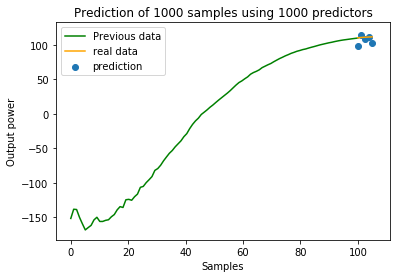

In [70]:
plt.plot(np.linspace(0, len(Y_train[-100:]), len(Y_train[-100:])), [y[0] for y in Y_train.values[-100:]], c = 'g')

plt.plot(np.linspace(100, 100 + len(Y_pred[0]), len(Y_pred[0])), Y_test.values[0], c = 'orange')
plt.scatter(np.linspace(100, 100 + len(Y_pred[0]), len(Y_pred[0])), Y_pred[0])

plt.title('Prediction of 1000 samples using 1000 predictors')
plt.xlabel('Samples')
plt.ylabel('Output power')
plt.legend(['Previous data', 'real data', 'prediction'])

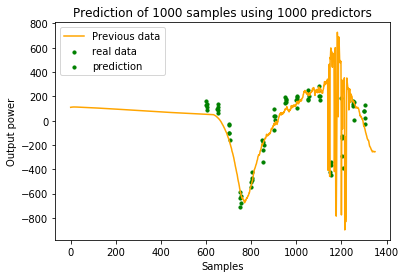

In [112]:
offset = 600
horizon = 50

error = []
# plt.plot(np.linspace(0, len(Y_train[-offset:]), len(Y_train[-offset:])), [y[0] for y in Y_train.values[-offset:]], c = 'g')

plt.plot(Y_test.values[:offset + 50 * 15, 0], c = 'orange')

for i in range(0, 15):
    plt.scatter(np.linspace(offset, offset + len(Y_pred[0]), len(Y_pred[0])), Y_pred[offset], c = 'g', s=10)
#     plt.plot(np.linspace(offset, offset + len(Y_pred[0]), len(Y_pred[0])), Y_pred[offset], c = 'g')
    offset += horizon
    
plt.title('Prediction of 1000 samples using 1000 predictors')
plt.xlabel('Samples')
plt.ylabel('Output power')
plt.legend(['Previous data', 'real data', 'prediction'])
    

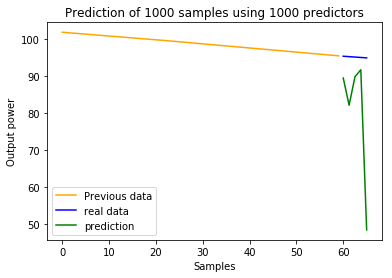

In [135]:
offset = 200
plt.plot(Y_test.values[offset - 60:offset, 0], c = 'orange')

for i in range(0, 1):
#     plt.scatter(np.linspace(60, 60 + len(Y_pred[0]), len(Y_pred[0])), Y_pred[offset], c = 'g', s=10)
    plt.plot(np.linspace(60, 60 + len(Y_pred[0]), len(Y_pred[0])), Y_test.values[offset : offset + 5, 0], c = 'blue')
    
    plt.plot(np.linspace(60, 60 + len(Y_pred[0]), len(Y_pred[0])), Y_pred[offset], c = 'g')
    
    offset += horizon
    
plt.title('Prediction of 1000 samples using 1000 predictors')
plt.xlabel('Samples')
plt.ylabel('Output power')
plt.legend(['Previous data', 'real data', 'prediction'])

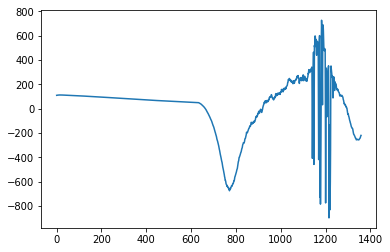

In [82]:
plt.plot(Y_test.values[:, 0])

In [137]:
import shap

In [152]:
new_labels = X_train.copy()

In [146]:
new_labels.columns = ['f' + str(i) for i in range(0, 104)]

In [147]:
new_labels.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103
0,119.56,119.58,119.60,119.61,119.63,119.65,119.67,119.68,119.70,119.72,...,5.291448,417.465994,182.50,-1473.1,918.23,0.202500,450.183352,191.205,-1473.1,918.23
1,119.58,119.60,119.61,119.63,119.65,119.67,119.68,119.70,119.72,119.73,...,5.220921,417.429426,182.48,-1473.1,918.23,0.187237,450.177423,191.200,-1473.1,918.23
2,119.60,119.61,119.63,119.65,119.67,119.68,119.70,119.72,119.73,119.75,...,5.150577,417.392973,182.46,-1473.1,918.23,0.171967,450.171486,191.170,-1473.1,918.23
3,119.61,119.63,119.65,119.67,119.68,119.70,119.72,119.73,119.75,119.77,...,5.080421,417.356637,182.44,-1473.1,918.23,0.156687,450.165543,191.105,-1473.1,918.23
4,119.63,119.65,119.67,119.68,119.70,119.72,119.73,119.75,119.77,119.79,...,5.010448,417.320416,182.42,-1473.1,918.23,0.141400,450.159593,191.040,-1473.1,918.23


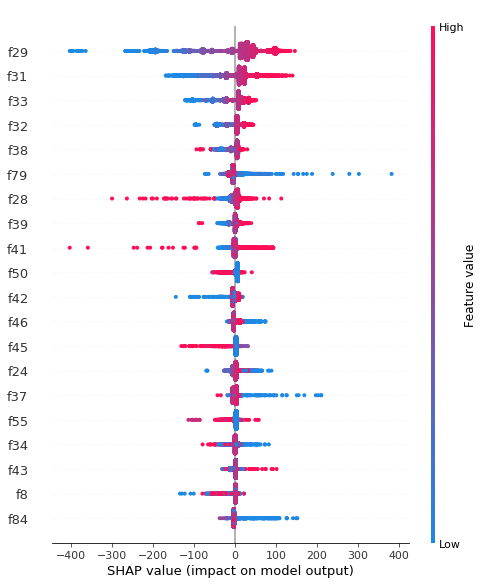

In [148]:
shap_values = shap.TreeExplainer(xbg_multi_reg.estimators_[0] ).shap_values(new_labels)
shap.summary_plot(shap_values, X_train, max_display=20)

In [162]:
for i in [29, 31, 33, 32, 38, 79, 28, 39]:
    print(X_train.columns[i], end=', ')

1_mean, 1_median, 1_max, 1_min, 5_max, 350_mean, value_29, 10_mean, 

In [157]:
X_train.head()

,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,...,2880_mean,2880_stddiv,2880_median,2880_min,2880_max,7200_mean,7200_stddiv,7200_median,7200_min,7200_max
0,119.56,119.58,119.60,119.61,119.63,119.65,119.67,119.68,119.70,119.72,...,5.291448,417.465994,182.50,-1473.1,918.23,0.202500,450.183352,191.205,-1473.1,918.23
1,119.58,119.60,119.61,119.63,119.65,119.67,119.68,119.70,119.72,119.73,...,5.220921,417.429426,182.48,-1473.1,918.23,0.187237,450.177423,191.200,-1473.1,918.23
2,119.60,119.61,119.63,119.65,119.67,119.68,119.70,119.72,119.73,119.75,...,5.150577,417.392973,182.46,-1473.1,918.23,0.171967,450.171486,191.170,-1473.1,918.23
3,119.61,119.63,119.65,119.67,119.68,119.70,119.72,119.73,119.75,119.77,...,5.080421,417.356637,182.44,-1473.1,918.23,0.156687,450.165543,191.105,-1473.1,918.23
4,119.63,119.65,119.67,119.68,119.70,119.72,119.73,119.75,119.77,119.79,...,5.010448,417.320416,182.42,-1473.1,918.23,0.141400,450.159593,191.040,-1473.1,918.23


## Train Multi Regressor models

In [24]:
from xgboost import XGBRegressor
from AutoValidator.MutliForecaster import MultiForecaster as mf

In [119]:
for train, test in trainingSets:
    xgb_reg = XGBRegressor(n_estimators=3000, learning_rate=0.1, colsample_bytree=0.3)
    forecaster = mf(xgb_reg, 5)
    
    Y_train = labels.values[len(train) + labelOffset - 10:][0]
    
    forecaster.fit(pd.DataFrame(train[labelOffset : ]), pd.DataFrame(labels.values[0 : len(train) - labelOffset]))
    
    forecaster.predict(pd.DataFrame(test[:1]))

In [ ]:
train[:, 0]

In [91]:
labels.values[0 + labelOffset - 10:][0]

array([-248.05, -246.28, -244.7 , -240.91, -236.15])

In [92]:
len(train)

3311

In [108]:
print(train[labelOffset : labelOffset + 10,0])

[120.2  120.26 120.32 120.38 120.44 120.5  120.56 120.62 120.68 120.74]


In [109]:
print(labels.values[ 0: 10, 0])

[120.2  120.26 120.32 120.38 120.44 120.5  120.56 120.62 120.68 120.74]


In [115]:
(train[labelOffset : ,0] ==labels.values[ 0: len(train) - labelOffset, 0]).any()

True

In [ ]:
len(test)

In [40]:
features.head()

,last_value,2nd_last_value,3rd_last_value,5_mean,5_stddiv,5_median,5_min,5_max,10_mean,10_stddiv,...,10080_mean,10080_stddiv,10080_median,10080_min,10080_max,43200_mean,43200_stddiv,43200_median,43200_min,43200_max
0,120.08,120.06,120.04,120.044,0.024166,120.04,120.01,120.08,120.000,0.050200,...,-2.017915,451.274525,191.155,-1473.1,1386.5,0.288695,388.607063,111.175,-1486.8,1386.5
1,120.14,120.08,120.06,120.070,0.038987,120.06,120.03,120.14,120.022,0.057931,...,-2.033342,451.267691,191.125,-1473.1,1386.5,0.290571,388.607446,111.210,-1486.8,1386.5
2,120.20,120.14,120.08,120.104,0.058515,120.08,120.04,120.20,120.048,0.071944,...,-2.048798,451.260836,191.105,-1473.1,1386.5,0.292451,388.607829,111.235,-1486.8,1386.5
3,120.26,120.20,120.14,120.148,0.074404,120.14,120.06,120.26,120.078,0.089420,...,-2.064284,451.253960,191.085,-1473.1,1386.5,0.294334,388.608214,111.250,-1486.8,1386.5
4,120.32,120.26,120.20,120.200,0.084853,120.20,120.08,120.32,120.113,0.107056,...,-2.079800,451.247063,191.040,-1473.1,1386.5,0.296220,388.608598,111.280,-1486.8,1386.5


In [41]:
labels.head()

,1,2,3,4,5
0,120.20,120.26,120.32,120.38,120.44
1,120.26,120.32,120.38,120.44,120.50
2,120.32,120.38,120.44,120.50,120.56
3,120.38,120.44,120.50,120.56,120.62
4,120.44,120.50,120.56,120.62,120.68


In [63]:
labelOffset = 2

In [64]:
features.values[labelOffset:labelOffset + 10][:, 0]

array([120.2 , 120.26, 120.32, 120.38, 120.44, 120.5 , 120.56, 120.62,
       120.68, 120.74])

In [65]:
labels.values[0:10, 0]

array([120.2 , 120.26, 120.32, 120.38, 120.44, 120.5 , 120.56, 120.62,
       120.68, 120.74])

In [26]:
labels[:10]

,1,2,3,4,5
0,120.20,120.26,120.32,120.38,120.44
1,120.26,120.32,120.38,120.44,120.50
2,120.32,120.38,120.44,120.50,120.56
3,120.38,120.44,120.50,120.56,120.62
4,120.44,120.50,120.56,120.62,120.68
5,120.50,120.56,120.62,120.68,120.74
6,120.56,120.62,120.68,120.74,120.80
7,120.62,120.68,120.74,120.80,120.86
8,120.68,120.74,120.80,120.86,120.92
9,120.74,120.80,120.86,120.92,120.98


### Learning

In [9]:
# 2 x 2 x 3
C = np.array([[[1,2, 10], [3, 4, 11]], [[5,6, 12], [7,8, 13]]])

In [138]:
for x in C:
    print(x)
    for y in x:
        print('\t', y)

[[ 1  2 10]
 [ 3  4 11]]
	 [ 1  2 10]
	 [ 3  4 11]
[[ 5  6 12]
 [ 7  8 13]]
	 [ 5  6 12]
	 [ 7  8 13]


In [180]:
C = C.reshape(4, 3)
C, C.shape

(array([[ 1,  2, 10],
        [ 3,  4, 11],
        [ 5,  6, 12],
        [ 7,  8, 13]]), (4, 3))

In [172]:
a, b = ['a', 'b'], ['1', '2']
A = np.repeat(a, len(a))
B = b * len(b)

In [176]:
df = pd.DataFrame(data=C.T, columns=pd.MultiIndex.from_tuples(zip(A, B)))

df

a       b    
    1   2   1   2
0   1   3   5   7
1   2   4   6   8
2  10  11  12  13

In [177]:
df['a']['1']

0     1
1     2
2    10
Name: 1, dtype: int32

In [178]:
data = data[:10000]

In [179]:
data.shape

(10000, 60)

In [181]:
horizon = 60

In [182]:
data.shape

(10000, 60)